In [56]:
import numpy as np
from numpy import random as rd
import time
import matplotlib.pyplot as plt
from solvers_listos import *
from funciones import *
from demandas import *

In [57]:
np.random.seed(3)
G, ubis, cap_tpte, info_locales = crear_grafo_inicial(archivo='n20estandar.xlsx', plot=False)

In [66]:
T = 500
tpo = np.arange(0,T,1)
F = 1
datos = simular_demanda_previa(G, dist = 'pir', T=T, d = 50) #Simular demanda previa
historia = {_:datos[_][:100] for _ in datos.keys()}

mu_demanda = {nodo: np.mean(historia[nodo]) for nodo in historia.keys()}
sd_demanda = {nodo: np.std(historia[nodo]) for nodo in historia.keys()}



UnboundLocalError: cannot access local variable 'demandas' where it is not associated with a value

In [ ]:
def demanda_real(G0, ruido=0, dist="n", T=100, d=30, demandas_in = {}, t=0):
    """
    Función que simula la demanda de los locales para un determinado periodo, recibe el tipo de demanda y los parámetros correspondientes.
    """
    grafo = G0.copy()
    demandas = {nodo: [] for nodo in grafo.nodes() if nodo != "N_0"}

    for nodo in grafo.nodes(data=True):
        if nodo[0] != "N_0":
            if dist == "n":
                dem = max(
                    np.random.normal(loc=nodo[1]["Prod"], scale=nodo[1]["Prod"] * 0.05)
                    + np.random.normal(loc=0, scale=nodo[1]["Prod"] * ruido),
                    0,
                )
            elif dist == "c": # peak central
                dem = demandas_in[nodo[0]][t]
            elif dist == "o": # oscilante
                dem = demandas_in[nodo[0]][t]
            elif dist == "d": # diagonal
                dem = demandas_in[nodo[0]][t]

            demandas[nodo[0]] = dem
    
    return demandas

In [ ]:
def SEDA(datos, historia=False, alpha=0.1, beta=0.1, theta=0.5):
    """
    Suavizamiento Exponencial Doble Amortiguado
    Aplica el método de suavizamiento exponencial doble a una serie de datos,
    específicamente el Método de Holt Damped.
    """
    I = [datos[0]]
    S = [datos[1] - datos[0]]
    for i in range(1, len(datos)):
        I.append(alpha * datos[i] + (1 - alpha) * (I[i - 1] + theta * S[i - 1]))
        S.append(beta * (I[i] - I[i - 1]) + (1 - beta) * S[i - 1])

    y = I[-1] + theta * S[-1]
    if historia == False:
        return y
    elif historia == True:
        I.append(y)
        return I
    elif historia == "S":
        return I, S


def pronostico_SEDA(datos, T, pron=False, alpha=0.1, beta=0.1, theta=0.5):
    """
    Devuelve un pronóstico para los siguientes T periodos mediante Suavizamiento Exponencial Doble Amortiguado
    """
    I, S = SEDA(datos, historia="S", alpha=alpha, beta=beta, theta=theta)
    pronostico = []
    for i in range(T):
        y = I[-1] + theta * S[-1]
        pronostico.append(y)
        I.append(alpha * y + (1 - alpha) * (I[-1] + theta * S[-1]))
        S.append(beta * (I[-1] - I[-2]) + (1 - beta) * S[-1])

    return pronostico


In [ ]:
nodo = 'N_1'
demandas = {'R': [], 'P': []}
error = []
error_mu = []
mu = np.mean(historia[nodo])
sd = np.std(historia[nodo])
for t in tpo:
    if t < 100:
        d_real = datos[nodo][t]
        pron = None
    else:
        d_real = datos[nodo][t]
        pron = pronostico_SEDA(historia[nodo], T = 1, pron = True, alpha=0.9, beta=0.2, theta=0.5)[0]
        error_t = 100*abs(d_real - pron)/d_real
        error_media = 100*abs(d_real - mu)/d_real
        historia[nodo].append(d_real)
        error.append(error_t)
        error_mu.append(error_media)
        # if t%10 == 0:
            # print(f"t = {t-100}, d_real = {round(d_real,3)}, pron = {round(pron,3)}, error = {round(error_t,3)}%")
        # print(f"t = {t-100}, d_real = {round(d_real,3)}, pron = {round(pron,3)}, error = {round(error_t,3)}%")
    demandas['R'].append(d_real)
    demandas['P'].append(pron)
print()
print(f'Error SEDA: {np.mean(error)}%')
print(f'Error media: {np.mean(error_mu)}%')


Error SEDA: 1.0886547611333108%
Error media: 72.93123846369619%


In [ ]:
def calibrar_pronostico(historia, dist = 'n'):
    pass

In [ ]:
nodo = 'N_1'
for _ in range(1,10):
    theta = _/10
    # demandas = {'R': [], 'P': []}
    error = []
    mu = np.mean(historia[nodo])
    sd = np.std(historia[nodo])
    for t in tpo:
        if t < 100:
            d_real = datos[nodo][t]
            pron = None
        else:
            d_real = datos[nodo][t]
            pron = pronostico_SEDA(historia[nodo], T = 1, pron = True, alpha=0.9, beta=0.3, theta=theta)[0]
            error_t = 100*abs(d_real - pron)/d_real

            historia[nodo].append(d_real)
            error.append(error_t)

    print()
    print(f'theta = {theta} | Error promedio: {np.mean(error)}%')


theta = 0.1 | Error promedio: 2.0057106171621406%

theta = 0.2 | Error promedio: 2.050308748096207%

theta = 0.3 | Error promedio: 2.0956706280672965%

theta = 0.4 | Error promedio: 2.1575557420925664%

theta = 0.5 | Error promedio: 2.2487902448416865%

theta = 0.6 | Error promedio: 2.3415970138939577%

theta = 0.7 | Error promedio: 2.4356309610162548%

theta = 0.8 | Error promedio: 2.5305375149855185%

theta = 0.9 | Error promedio: 2.6265793664646755%


In [ ]:
np.mean(error)

2.6265793664646755

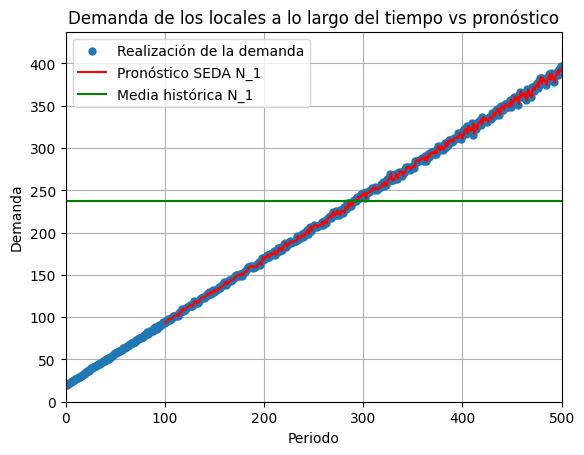

In [ ]:
fig, ax = plt.subplots()
ax.set(xlabel='Periodo', ylabel='Demanda', title='Demanda de los locales a lo largo del tiempo vs pronóstico')
ax.grid()
ax.plot(tpo, demandas['R'], 'o', label='Realización de la demanda', markersize=5)
ax.plot(tpo, demandas['P'], 'r', label=f'Pronóstico SEDA {nodo}')
ax.plot(tpo, [mu]*len(tpo), 'g', label=f'Media histórica {nodo}')
ax.legend()
ax.set_xlim(0, T)
ax.set_ylim(0, max(demandas['R'])*1.1)
plt.show()
